# Environment Preparation

In [ ]:
# only for google colab
! git clone https://github.com/ferisetiawan/MNISTFederatedLearning
! cp MNISTFederatedLearning/*.py .
! pip install -r MNISTFederatedLearning/requirements.txt

Cloning into 'bfpytorch'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 320 (delta 74), reused 121 (delta 44), pack-reused 169
Receiving objects: 100% (320/320), 11.87 MiB | 25.37 MiB/s, done.
Resolving deltas: 100% (155/155), done.


In [ ]:
from mnist_utils import get_MNIST_dataloaders

default_training_dataloader, default_testing_dataloader = get_MNIST_dataloaders()

default_training_dataset = default_training_dataloader.dataset
default_testing_dataset = default_testing_dataloader.dataset

print('Training dataset size:', len(default_training_dataset))
print('Testing dataset size:', len(default_testing_dataset))

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!
Training dataset size: 60000
Testing dataset size: 10000


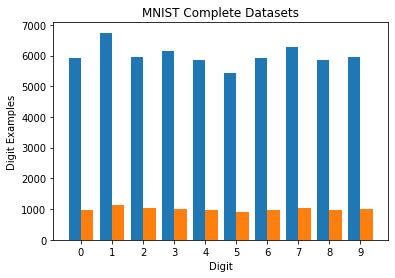

In [ ]:
from mnist_utils import plot_digit_histogram

plot_digit_histogram([default_training_dataloader, default_testing_dataloader], title='MNIST Complete Datasets')

# Baseline Non-Federative Learning Approach

In [ ]:
import torch
from mnist_utils import DefaultNet
from mnist_utils import split_dataset

# default training rounds
default_n_rounds = 10

# target for quitting early (helps to compare approaches more quickly)
default_target_accuracy = None

# Get model and test data
model = DefaultNet()
test_samples, test_labels = split_dataset(default_testing_dataset)

# Load model and test data to the GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # smoke 'em if you got 'em
model = model.to(device)
test_samples = test_samples.to(device)
test_labels = test_labels.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.02, momentum=0.5)
#optimizer = torch.optim.Adadelta(model.parameters(), lr=1.) # original sample optimizer
loss_function = torch.nn.CrossEntropyLoss()

print('Device:', device)
print('Model:', model)
print('Optimizer:', optimizer)
print('Loss function:', loss_function)
print("Training dataset size:", len(default_training_dataloader.dataset))
print("Testing dataset size:", len(default_testing_dataset))

Device: cpu
Model: DefaultNet(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.02
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
Loss function: CrossEntropyLoss()
Training dataset size: 60000
Testing dataset size: 10000


In [ ]:
from mnist_utils import print_training_update
from tqdm.notebook import tqdm
from tqdm.notebook import trange

nonfederated_history = {'test_loss': [], 'test_accuracy': []}

for epoch in trange(default_n_rounds):
    
    # train the model
    model.train(True)
    for i, (training_samples, training_labels) in enumerate(default_training_dataloader):
        training_samples = training_samples.to(device)
        training_labels = training_labels.to(device)
        
        optimizer.zero_grad()
        training_predictions = model(training_samples)
        training_loss = loss_function(training_predictions, training_labels)
        training_loss.backward()
        optimizer.step()

    # test the model
    model.train(False)
    with torch.no_grad():
        output = model(test_samples)
        output = output.to(device)
        
        test_loss = loss_function(output, test_labels).item()
        test_predicted_classes = output.argmax(dim=1, keepdim=True)
        n_correct = test_predicted_classes.eq(test_labels.view_as(test_predicted_classes)).sum().item()
    accuracy = (n_correct / len(test_labels)) * 100.

    #record loss and accuracy
    nonfederated_history['test_loss'].append(test_loss)
    nonfederated_history['test_accuracy'].append(accuracy)
    print_training_update('Round {:3}'.format(epoch), nonfederated_history, id(model))

Round   0	loss: 0.1844 (+0.0000)	acc: 94.43% ( +0.00%)	model: 98984
Round   1	loss: 0.1223 (-0.0620)	acc: 96.33% ( +1.90%)	model: 98984
Round   2	loss: 0.0974 (-0.0249)	acc: 96.90% ( +0.57%)	model: 98984
Round   3	loss: 0.0824 (-0.0150)	acc: 97.41% ( +0.51%)	model: 98984
Round   4	loss: 0.0759 (-0.0065)	acc: 97.69% ( +0.28%)	model: 98984
Round   5	loss: 0.0702 (-0.0057)	acc: 97.97% ( +0.28%)	model: 98984
Round   6	loss: 0.0657 (-0.0045)	acc: 97.94% ( -0.03%)	model: 98984
Round   7	loss: 0.0661 (+0.0004)	acc: 97.89% ( -0.05%)	model: 98984
Round   8	loss: 0.0638 (-0.0023)	acc: 98.02% ( +0.13%)	model: 98984
Round   9	loss: 0.0625 (-0.0014)	acc: 98.07% ( +0.05%)	model: 98984



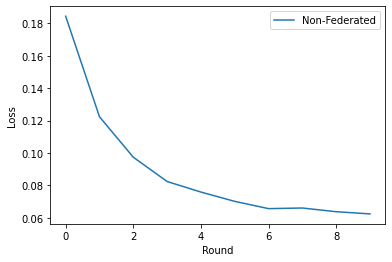

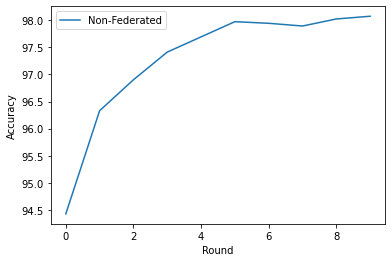

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(nonfederated_history['test_loss'], label='Non-Federated')
ax.set_xlabel("Round")
ax.set_ylabel("Loss")
ax.legend();

fig, ax = plt.subplots()
ax.plot(nonfederated_history['test_accuracy'], label='Non-Federated')
ax.set_xlabel("Round")
ax.set_ylabel("Accuracy")
ax.legend();

# Federated Learning Approach (Simulation) - Dataset with Equal Distribution

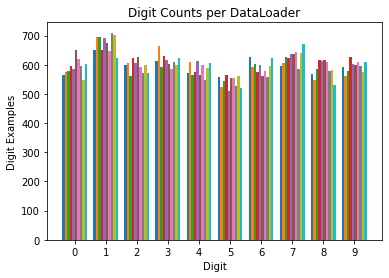

In [ ]:
from mnist_utils import make_federated_dataloaders

federated_equal_dataloaders = make_federated_dataloaders(default_training_dataset, p=0.0)

plot_digit_histogram(federated_equal_dataloaders, 'Digit Counts per DataLoader')

In [ ]:
from federated import FederatedManager
from federated import FederatedWorker
from federated import plot_managers

federated_equal_manager = FederatedManager('Federated Unbiased', federated_equal_dataloaders, default_testing_dataset, DefaultNet, verbose=True)
federated_equal_manager.learn(default_n_rounds, default_target_accuracy)

# a proxy to compare the nonfederated model to federated managers
nonfederated_manager = FederatedManager('Non-Federated', [default_training_dataloader], default_testing_dataset, DefaultNet)
nonfederated_manager.history = nonfederated_history

Federated Unbiased manager training with 10 worker(s) for 10 rounds.



Round 0   workers:
	worker  0:	loss: 0.5612 (+0.0000)	acc: 85.43% ( +0.00%)	model: 06824
	worker  1:	loss: 0.5524 (+0.0000)	acc: 86.32% ( +0.00%)	model: 76568
	worker  2:	loss: 0.5474 (+0.0000)	acc: 86.08% ( +0.00%)	model: 75496
	worker  3:	loss: 0.6045 (+0.0000)	acc: 81.09% ( +0.00%)	model: 44728
	worker  4:	loss: 0.5443 (+0.0000)	acc: 85.82% ( +0.00%)	model: 45120
	worker  5:	loss: 0.6371 (+0.0000)	acc: 80.59% ( +0.00%)	model: 65544
	worker  6:	loss: 0.5463 (+0.0000)	acc: 85.28% ( +0.00%)	model: 68264
	worker  7:	loss: 0.5644 (+0.0000)	acc: 85.08% ( +0.00%)	model: 60680
	worker  8:	loss: 0.5592 (+0.0000)	acc: 85.00% ( +0.00%)	model: 58888
	worker  9:	loss: 0.5465 (+0.0000)	acc: 86.08% ( +0.00%)	model: 06128

Round 0   combined:	loss: 0.5378 (+0.0000)	acc: 86.65% ( +0.00%)	model: 09080

Round 1   workers:
	worker  0:	loss: 0.3654 (-0.1958)	acc: 89.45% ( +4.02%)	model: 76264
	worker  1:	loss: 0.4218 (-0.1306)	acc: 87.36% ( +1.04%)	model: 95176
	worker  2:	loss: 0.3671 (-0.1804)	acc: 8

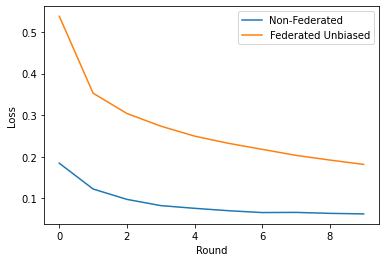

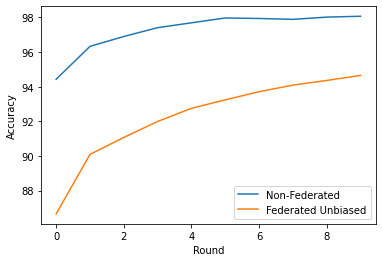

In [ ]:
plot_managers([nonfederated_manager, federated_equal_manager])

# Federated Learning Approach - Dataset with Unbalanced Distribution

In [ ]:
federated_biased_dataloaders = make_federated_dataloaders(default_training_dataset, p=0.15)
worker_example_counts = [len(dataloader.dataset) for dataloader in federated_biased_dataloaders]

print(worker_example_counts)
print(sum(worker_example_counts))

[6144, 6055, 5991, 5921, 5901, 5967, 5970, 6050, 5976, 6025]
60000


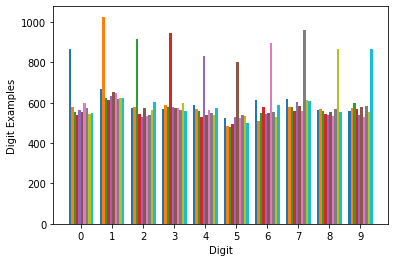

In [ ]:
plot_digit_histogram(federated_biased_dataloaders)

In [ ]:
from mnist_utils import print_dataset_counters
print_dataset_counters([dataloader.dataset for dataloader in federated_biased_dataloaders])

Counter({0: 866, 1: 668, 7: 617, 6: 616, 4: 590, 2: 575, 3: 567, 8: 563, 9: 559, 5: 523})
Counter({1: 1027, 3: 587, 7: 581, 0: 580, 2: 577, 9: 574, 8: 568, 4: 567, 6: 508, 5: 486})
Counter({2: 915, 1: 622, 9: 598, 3: 581, 7: 578, 4: 558, 8: 558, 0: 553, 6: 549, 5: 479})
Counter({3: 948, 1: 616, 6: 578, 9: 567, 7: 559, 2: 546, 8: 543, 0: 541, 4: 528, 5: 495})
Counter({4: 830, 1: 636, 7: 604, 3: 580, 0: 564, 6: 546, 9: 541, 8: 540, 5: 532, 2: 528})
Counter({5: 804, 1: 655, 7: 583, 9: 577, 3: 576, 2: 575, 8: 555, 0: 553, 6: 550, 4: 539})
Counter({6: 899, 1: 650, 0: 597, 3: 573, 4: 565, 7: 561, 8: 535, 2: 534, 9: 531, 5: 525})
Counter({7: 960, 1: 621, 9: 582, 0: 573, 8: 567, 3: 563, 6: 555, 4: 549, 5: 541, 2: 539})
Counter({8: 867, 1: 624, 7: 615, 3: 597, 2: 565, 9: 555, 0: 547, 4: 541, 5: 537, 6: 528})
Counter({9: 865, 1: 623, 7: 607, 2: 604, 6: 589, 4: 575, 3: 559, 8: 555, 0: 549, 5: 499})


In [ ]:
federated_biased_manager = FederatedManager('Fed Biased 0.15', federated_biased_dataloaders, default_testing_dataset, DefaultNet, verbose = True)
federated_biased_manager.learn(default_n_rounds, default_target_accuracy)

Fed Biased 0.15 manager training with 10 worker(s) for 10 rounds.



Round 0   workers:
	worker  0:	loss: 0.5466 (+0.0000)	acc: 85.07% ( +0.00%)	model: 95848
	worker  1:	loss: 0.5939 (+0.0000)	acc: 82.69% ( +0.00%)	model: 36488
	worker  2:	loss: 0.5549 (+0.0000)	acc: 85.32% ( +0.00%)	model: 37216
	worker  3:	loss: 0.5835 (+0.0000)	acc: 85.33% ( +0.00%)	model: 36432
	worker  4:	loss: 0.5679 (+0.0000)	acc: 84.28% ( +0.00%)	model: 38392
	worker  5:	loss: 0.5594 (+0.0000)	acc: 84.22% ( +0.00%)	model: 38056
	worker  6:	loss: 0.5572 (+0.0000)	acc: 84.72% ( +0.00%)	model: 38224
	worker  7:	loss: 0.5479 (+0.0000)	acc: 85.88% ( +0.00%)	model: 11808
	worker  8:	loss: 0.5800 (+0.0000)	acc: 83.76% ( +0.00%)	model: 63792
	worker  9:	loss: 0.5689 (+0.0000)	acc: 85.10% ( +0.00%)	model: 64912

Round 0   combined:	loss: 0.5389 (+0.0000)	acc: 86.64% ( +0.00%)	model: 36712

Round 1   workers:
	worker  0:	loss: 0.3650 (-0.1817)	acc: 89.65% ( +4.58%)	model: 43440
	worker  1:	loss: 0.3798 (-0.2141)	acc: 89.01% ( +6.32%)	model: 37496
	worker  2:	loss: 0.3839 (-0.1711)	acc: 8

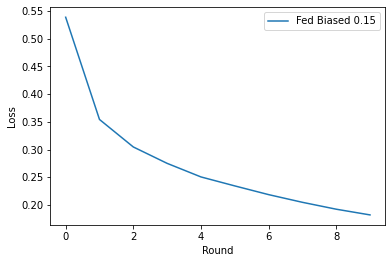

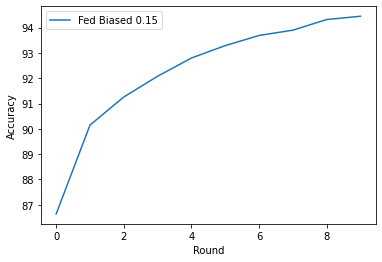

In [ ]:
plot_managers(federated_biased_manager)

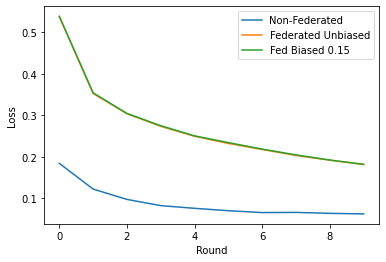

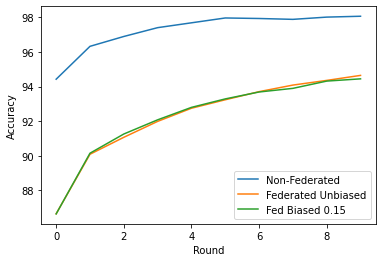

In [ ]:
plot_managers([nonfederated_manager, federated_equal_manager, federated_biased_manager])

Fed Bias 0.0 manager training with 10 worker(s) for 10 rounds.



Fed Bias 0.0 manager trained 10 rounds. (Test accuracy 94.76% and loss 0.1793.)
Fed Bias 0.4 manager training with 10 worker(s) for 10 rounds.



Fed Bias 0.4 manager trained 10 rounds. (Test accuracy 94.31% and loss 0.1948.)
Fed Bias 0.8 manager training with 10 worker(s) for 10 rounds.



Fed Bias 0.8 manager trained 10 rounds. (Test accuracy 92.03% and loss 0.2701.)
Fed Bias 0.9 manager training with 10 worker(s) for 10 rounds.



Fed Bias 0.9 manager trained 10 rounds. (Test accuracy 90.40% and loss 0.3349.)
Fed Bias 0.95 manager training with 10 worker(s) for 10 rounds.



Fed Bias 0.95 manager trained 10 rounds. (Test accuracy 88.05% and loss 0.4556.)
Fed Bias 0.98 manager training with 10 worker(s) for 10 rounds.



Fed Bias 0.98 manager trained 10 rounds. (Test accuracy 83.63% and loss 0.7151.)
Fed Bias 0.99 manager training with 10 worker(s) for 10 rounds.



Fed Bias 0.99 manager trained 10 rounds. (Test accuracy 77.15% and loss 0.9812.)
Fed Bias 1.0 manager training with 10 worker(s) for 10 rounds.



Fed Bias 1.0 manager trained 10 rounds. (Test accuracy 74.07% and loss 1.5999.)



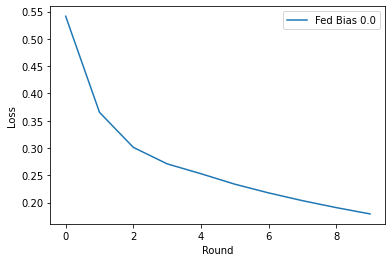

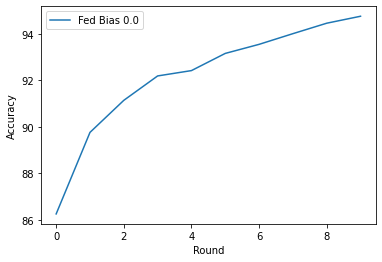

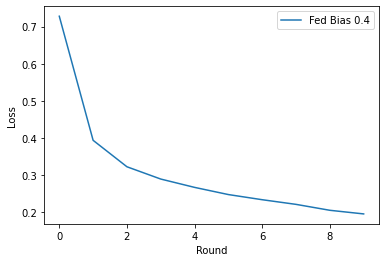

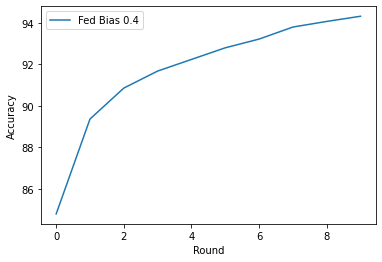

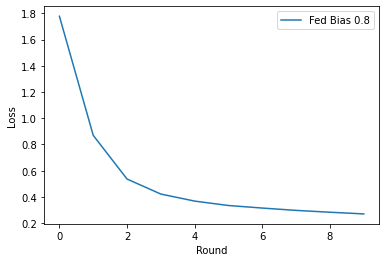

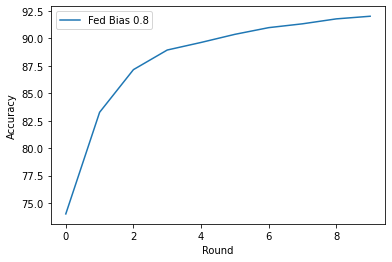

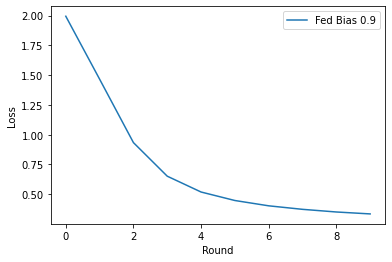

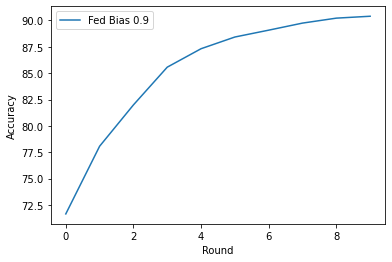

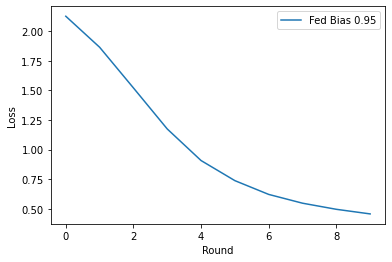

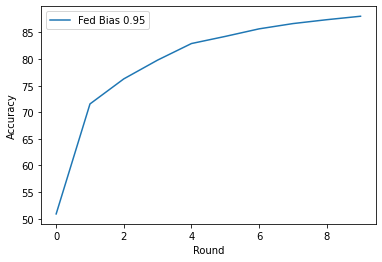

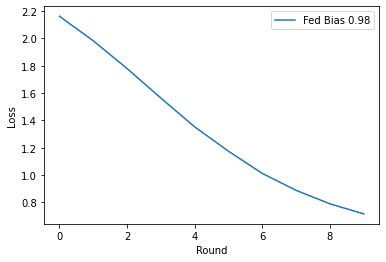

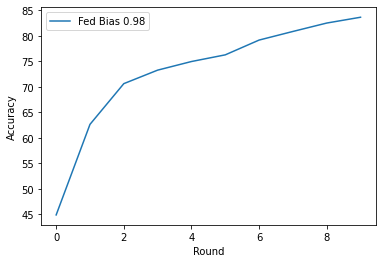

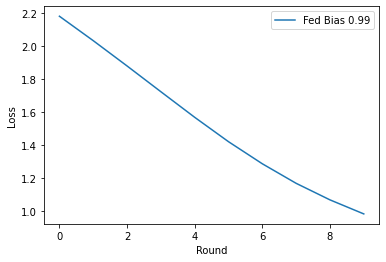

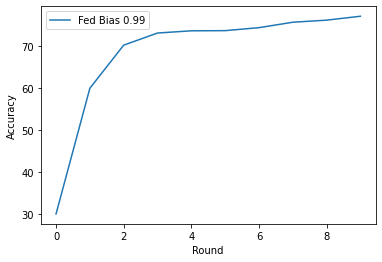

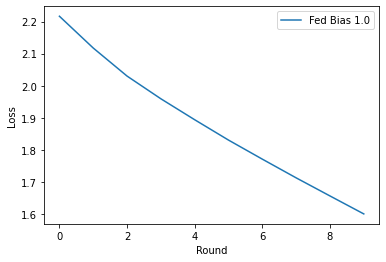

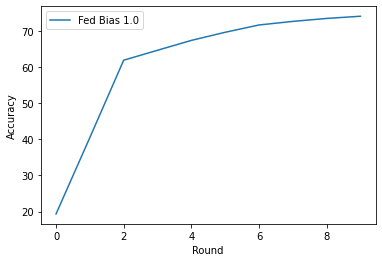

In [ ]:
from federated import evaluate_new_manager

bias_comparison_managers = [evaluate_new_manager('Fed Bias '+ str(bias), default_training_dataset, default_testing_dataset, p=bias, n_rounds=default_n_rounds, target_accuracy=default_target_accuracy, model=DefaultNet) for bias in tqdm([0.0, 0.4, 0.8, 0.9, 0.95, 0.98, 0.99, 1.0], desc='Managers')]

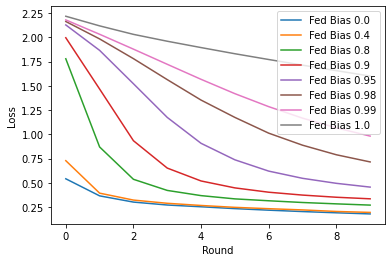

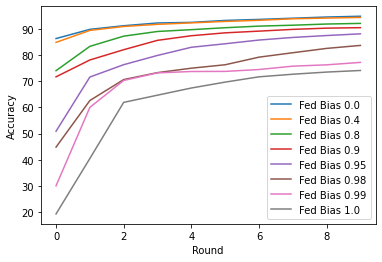

In [ ]:
plot_managers(bias_comparison_managers)